In [2]:
pip install torch torchvision  matplotlib numpy scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Laden der Packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [6]:
#Laden und teilen des Datensatzes
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Load data from sklearn
mnist = fetch_openml('mnist_784',parser='auto')

data = mnist.data.to_numpy().reshape(-1, 1, 28, 28).astype(np.float32) / 255  # normalize the data to [0, 1]
targets = mnist.target.to_numpy().astype(np.int64)  # targets are the labels

# Split data into training and testing sets
train_data, test_data = data[:60000], data[60000:]
train_targets, test_targets = targets[:60000], targets[60000:]

train_dataset = MNISTDataset(train_data, train_targets)
test_dataset = MNISTDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
#Definieren und initialisieren des CNNs
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

model = CNN()

In [8]:
#Trainieren und Testen des CNNs
def train(model, train_loader, epochs=2):
    
    # Define a loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))

# Testing loop
def test(model, test_loader):
    
    # Define a loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Train the model
train(model, train_loader, epochs=2)

# Test the model
test(model, test_loader)

model.eval()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312115
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.714846
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.667602
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.493477
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.559973
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.245703
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.380014
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.408098
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.275202
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.347491
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.211366
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.519571
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.542301
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.247808
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.400136
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.346765
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.307084
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.168199
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.191739
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.109420

Test set: A

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

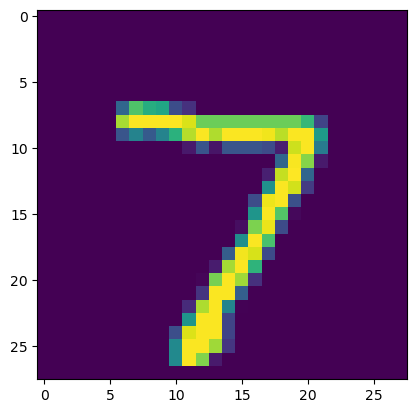

In [9]:
#Testen und grafisches anzeigen von einer Instanz
data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
data_iter = iter(data_loader)

test_img, label = next(data_iter)

test_img_data = np.asarray(test_img)
test_img_data = np.squeeze(test_img_data )
plt.imshow(test_img_data)
plt.show()

output = model(test_img)

pred = output.argmax()